### JWST Pipeline Processing of Wide Slitless Spectroscopy Exposures

#### Calspec2 steps       
    
- assign_wcs: Assigns a WCS object to dispersed exposures              
- background: Background subtraction                
- flatfield: Flat fielding             
- extract_2d: Extract cutouts  
- photom: Photometric correction      
- extract_1d: Extract 1D spectrum   


#### Calspec3 steps
 
- exp_to_source: Reformat files to contain one source from multiple exposures
- extract_1d: Final 1D extraction    
- combine_1d: Combine 1D spectra     


#### assign_wcs

The *assign_wcs* step creates and assigns a WCS to each SCI exposure. The JWST pipeline uses gWCS (more flexible than FITS WCS) to perform the transformations and the ASDF standard to save the WCS to a file. 

The reference files contain the calibrated distortion models and wavelength solutions and are also saved in the ASDF format in the [JWST CRDS](https://jwst-crds.stsci.edu).

*assign_wcs* operates on single SCI exposures using a previously created catalog of objects. The name of the catalog is saved as a keyword in the primary FITS header of the SCI file.
Essentially the pipeline runs first calimage2 on the direct images in an association, adds the name of the catalog file to the association and saves it in the dispersed image header. At this point calspec2 runs on the dispersed image. This notebook describes the steps in calspec2.


A simulated NIRCAM grism image is used in the examples. 

In [2]:
fname = "jw01076006002_0117x_00003_nrcb5_uncal_dispersed_GRISMR_crossing_F444W_assign_wcs.fits"

In [3]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import patches

In [4]:
import asdf
import numpy as np

from astropy.modeling.models import *
from astropy.modeling.models import math as astmath

from jwst import datamodels
from jwst.assign_wcs import util
from jwst.assign_wcs import nircam
from jwst.transforms.models import (NIRCAMForwardRowGrismDispersion,
                                    NIRCAMBackwardGrismDispersion)

from gwcs import coordinate_frames as cf
from astropy import units as u

#### Read the data from the reference file

In [5]:
reference_files = {
    'distortion': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_distortion_0096.asdf',
    'specwcs': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_specwcs_0009.asdf',
    'wavelengthrange': '/Users/dencheva/crds/references/jwst/nircam/jwst_nircam_wavelengthrange_0003.asdf'
    }


specwcs = asdf.open(reference_files['specwcs']).tree
displ = specwcs['displ']
dispx = specwcs['dispx']
dispy = specwcs['dispy']
invdispl = specwcs['invdispl']
invdispx = specwcs['invdispx']
invdispy = specwcs['invdispy']
orders = specwcs['orders']

print('orders', orders)
print('dispersion_wavelength', displ)



orders [1, 2]
dispersion_wavelength [<Polynomial1D(1, c0=2.4, c1=2.6)>, <Polynomial1D(1, c0=2.4, c1=2.6)>]


#### Construct the WCS pipeline

The code snippet below shows two of the major advantages of gWCS to FITS WCS:

- Combine arbitrary transforms in an arbitrary way.

- The WCS pipeline is a list of steps where each step is defined by a coordinate system and the transform to the next coordinate system in the WCS pipeline, **(coord_frame, transform)**.There are tools to create custom coordinate frames to be used as intermediate frames in the WCS pipeline. Furthermore, one can retrieve the transform between any two  frames. This, essentially, provides an opportunity for WCS designers to choose places (stops) in the WCS pipeline where it makes sense to provide the user with the option to compute intermediate results.

Here we call a class which constructs the pipeline. At the end of the notebook there's a functional form of this class to illustrate what it is doing under the hood.

In [6]:
# open the dispersed exposure
input_model = datamodels.open(fname)

The imaging part of the WCS uses the distortion for imaging mode. This is created in the same way as regular images.

In [7]:
image_pipeline = nircam.imaging(input_model, reference_files)
print(image_pipeline[1])

(<Frame2D(name="v2v3", unit=(Unit("arcsec"), Unit("arcsec")), axes_names=('x', 'y'), axes_order=(0, 1))>, <CompoundModel(factor_0=0.00027778, factor_1=0.00027778, angles_2=[  0.02488792,  -0.1365206 , -10.13385809,  70.07217507,  80.96155679])>)


Now let's create a custom coordinate frame associated with the grism image.

In [8]:
gdetector = cf.Frame2D(name='grism_detector', 
                       axes_order=(0, 1),
                       unit=(u.pix, u.pix))

**Question for Meg: Is this the correct interpretation of inputs and outputs?**

Create the transform between the image detector and the grism detector.
It will take as inputs 

- xdirect, ydirect: x, y coordinates in the direct image
- x0, y0: center of an object (from catalog or user supplied)
- order: spectral order

It will return

- xgrism, ygrism: xgrism + dx, ygrism
- lam: wavelength
- order: spectral order

In [9]:
det2det = NIRCAMForwardRowGrismDispersion(orders,
                                          lmodels=displ,
                                          xmodels=invdispx,
                                          ymodels=dispy)

**Question for Meg: Is this the correct interpretation of inputs and outputs?**

And assign an inverse to this transform.
The inverse transform takes inputs:

- xdispersed, ysdispersed
- wavelength
- order

It returns

- xdispersed, ydispersed
- x0, y0
- order


In [10]:
det2det.inverse = NIRCAMBackwardGrismDispersion(orders,
                                                    lmodels=invdispl,
                                                    xmodels=dispx,
                                                    ymodels=dispy)

In [11]:
grism_pipeline = [(gdetector, det2det)]
imagepipe = []
world = image_pipeline.pop()
for cframe, trans in image_pipeline:
    trans = trans & (Identity(2))
    imagepipe.append((cframe, trans))
imagepipe.append((world))
grism_pipeline.extend(imagepipe)

The final WCS object.

Inputs are (x_dispersed, y_dispersed, x0, y0, order).

Outputs are RA, DEC, wavelength.

In [12]:
from gwcs import WCS

wcsobj = WCS(grism_pipeline)
print(wcsobj)


     From                   Transform             
-------------- -----------------------------------
grism_detector nircam_forward_row_grism_dispersion
      detector                       CompoundModel
          v2v3                       CompoundModel
         world                                None


#### Working with the WCS object

In [13]:
x0=917
y0=800
order=1
x=919
y=806

print("RA, DEC, lam for order=1 :")
print(wcsobj(x, y, x0, y0, 1))

print("RA, DEC, lam for order=2 :")
print(wcsobj(x, y, x0, y0, 2))

2020-05-10 09:59:36,930 - stpipe - WARNING - /Users/dencheva/dev/astropy/astropy/modeling/math_functions.py:54: AstropyUserWarning: Models in math_functions are experimental.
  warnings.warn("Models in math_functions are experimental.", AstropyUserWarning)



RA, DEC, lam for order=1 :
(80.96491020650988, -70.07637313843853, 3.934991999972275, 1.0)
RA, DEC, lam for order=2 :
(80.96491020650988, -70.07637313843853, 1.9674960000086115, 2.0)


Now let's see how to get x, y, in the dispersed image. We can retrieve a transform between any two coordinate frames in the pipeline.

In [15]:
wcsobj.available_frames

['grism_detector', 'detector', 'v2v3', 'world']

In [17]:
grism2image = wcsobj.get_transform('grism_detector', 'detector')

x, y, wav, order = grism2image(x, y, x0, y0, order)
print(x, y, wav, order)

917.0 800.0 3.934991999972275 1.0


In [18]:
grism2image.inverse(917, 800, 3.934991999972275, 1)

(918.9999999999998, 800.0, 917.0, 800.0, 1.0)

*assign_wcs* works similarly to *grismconf*, the packaging of reference files and code organozation is different.

#### Background subtraction

For Wide-Field Slitless Spectroscopy expsoures, a background reference image is subtracted from the target exposure. Before being subtracted, the background reference image is scaled to match the signal level of the target data within background (source-free) regions of the image.

More details on the background subtraction step are in the [documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background/description.html#wfss-mode).

#### Flat field

The flat field step subtract a flat image from the grism image. Currently the pipeline does not use wavelength dependent flats. **(Howard, is this correct? Are there plans to use wavelength dependent flat fields? I'm asking because it came up in other meetings.)**

#### extract_2d

Uses the source catalog specified in the SCI heasder.
Alternatively a user can specify a list of grism objects. A [grism object](https://github.com/spacetelescope/jwst/blob/085801ffaed3df70d4013c3936f0bcde74646eb7/jwst/transforms/models.py#L46) is a named tuple which stores information about a dispersed object.

The sensitivity information from the original aXe style configuration file needs to be modified by the passband of the filter used for the direct image to get the min and max wavelengths which correspond to t=0 and t=1. This has been done by the team and the min and max wavelengths to use to calculate t are stored in the grism wavelengthrange reference file.

Steps in extract_2d:

- Read the catalog and create a list of [sky objects](https://github.com/spacetelescope/jwst/blob/master/jwst/assign_wcs/util.py#L408)
- Create a bounding box for each spectrum.
  The footprint of the object on the sky is passed through the inverse WCS of the
  direct image and then trhough the trace polynomials to find the location of the
  corners on the dispersed image.
- The center of the object in the direct image frame is computed by evaluating the 
  inverse WCS of the direct image on the sky centroid
- The data arrays are extracted using the bounding_box for each spectral_order

In [19]:
skyobject_list = util.get_object_info(input_model.meta.source_catalog)
print(skyobject_list[0])

id: 1
xcentroid: 359.6261559130633 pix
ycentroid: 4.480905309614455 pix
sky_centroid: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98653193, -70.09203073)>
abmag: 21.115360260009766
abmag_error: 0.015586755238473415
sky_bbox_ll: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98670482, -70.09211204)>
sky_bbox_lr: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98619866, -70.09208128)>
sky_bbox_ul: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98679514, -70.09193968)>
sky_bbox_ur: <SkyCoord (ICRS): (ra, dec) in deg
    (80.98628899, -70.09190893)>



In [21]:
len(skyobject_list)


830

In [22]:
# Create the bounding_box of each object in the dispersed image
grism_objects = util.create_grism_bbox(input_model, reference_files,
                                       extract_orders=[1],
                                       mmag_extract=20)

2020-05-10 10:00:03,956 - stpipe - INFO - Extracting objects < abmag = 20
2020-05-10 10:00:03,957 - stpipe - INFO - Getting objects from jw01076006002_0117y_00004_nrcb5_cat.ecsv
2020-05-10 10:00:04,788 - stpipe - INFO - Partial order on detector for obj: 7 order: 1
2020-05-10 10:00:04,801 - stpipe - INFO - Partial order on detector for obj: 9 order: 1
2020-05-10 10:00:04,816 - stpipe - INFO - Partial order on detector for obj: 11 order: 1
2020-05-10 10:00:04,830 - stpipe - INFO - Partial order on detector for obj: 16 order: 1
2020-05-10 10:00:04,847 - stpipe - INFO - Partial order on detector for obj: 28 order: 1
2020-05-10 10:00:04,865 - stpipe - INFO - Partial order on detector for obj: 38 order: 1
2020-05-10 10:00:04,882 - stpipe - INFO - Partial order on detector for obj: 50 order: 1
2020-05-10 10:00:04,902 - stpipe - INFO - Partial order on detector for obj: 55 order: 1
2020-05-10 10:00:04,922 - stpipe - INFO - Partial order on detector for obj: 59 order: 1
2020-05-10 10:00:04,942

2020-05-10 10:00:07,231 - stpipe - INFO - Partial order on detector for obj: 680 order: 1
2020-05-10 10:00:07,247 - stpipe - INFO - Partial order on detector for obj: 696 order: 1
2020-05-10 10:00:07,287 - stpipe - INFO - Partial order on detector for obj: 718 order: 1
2020-05-10 10:00:07,302 - stpipe - INFO - Partial order on detector for obj: 730 order: 1
2020-05-10 10:00:07,315 - stpipe - INFO - Partial order on detector for obj: 734 order: 1
2020-05-10 10:00:07,331 - stpipe - INFO - Partial order on detector for obj: 736 order: 1
2020-05-10 10:00:07,385 - stpipe - INFO - Partial order on detector for obj: 748 order: 1
2020-05-10 10:00:07,400 - stpipe - INFO - Partial order on detector for obj: 750 order: 1
2020-05-10 10:00:07,427 - stpipe - INFO - Partial order on detector for obj: 758 order: 1
2020-05-10 10:00:07,467 - stpipe - INFO - Partial order on detector for obj: 766 order: 1
2020-05-10 10:00:07,481 - stpipe - INFO - Partial order on detector for obj: 767 order: 1
2020-05-10

In [ ]:
print('number of grism objects:', len(grism_objects))


In [23]:
print('order, y_bbox, x_bbox')
[g.order_bounding for g in grism_objects[:10]]

order, y_bbox, x_bbox


[{1: ((1, 15), (94, 1273))},
 {1: ((7, 23), (26, 1209))},
 {1: ((10, 24), (-57, 1120))},
 {1: ((16, 52), (-75, 1084))},
 {1: ((21, 34), (-144, 1039))},
 {1: ((22, 37), (904, 2085))},
 {1: ((67, 76), (-699, 489))},
 {1: ((86, 115), (989, 2154))},
 {1: ((126, 140), (-688, 488))},
 {1: ((151, 162), (-586, 598))}]

In [24]:
x2d = datamodels.open('nrc_dispersed_extract_2d.fits')

<IPython.core.display.Javascript object>


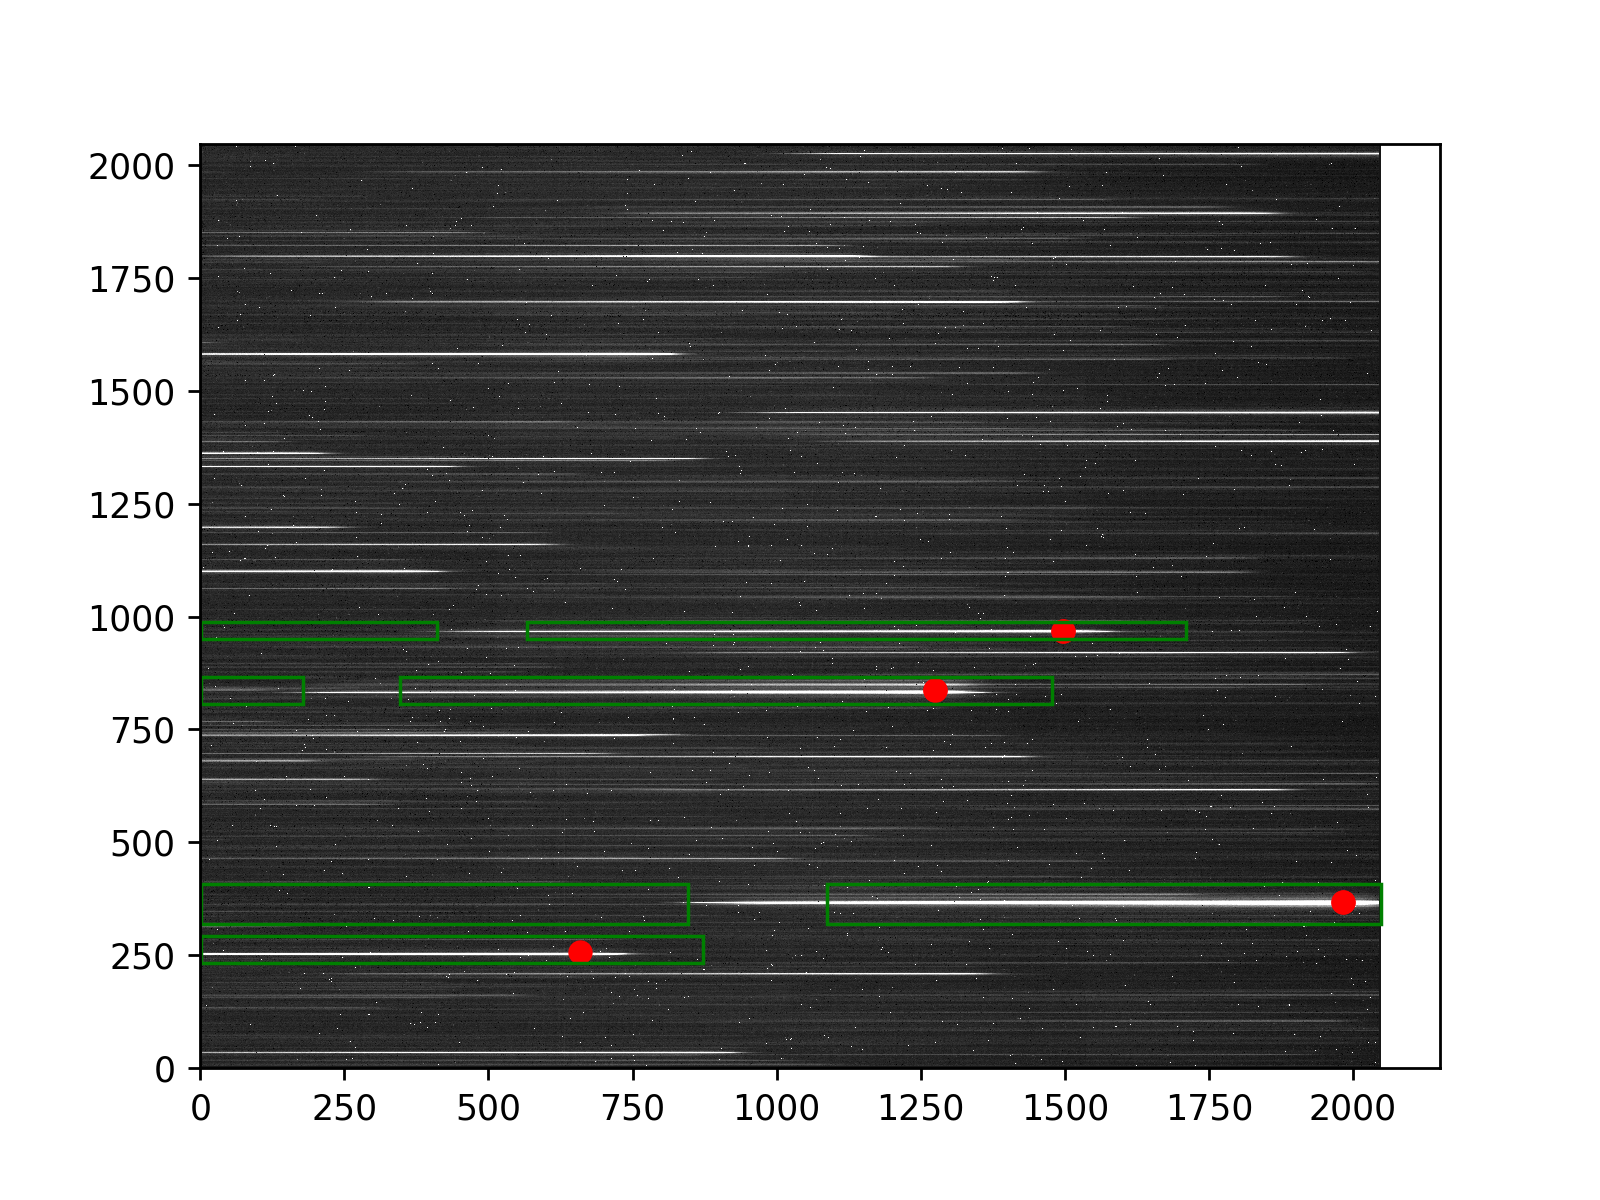

In [40]:
ax = plt.subplot(111)
plt.gray()

for slit in x2d.slits:
    bbox = slit.meta.wcs.bounding_box
    xstart, ystart = slit.xstart, slit.ystart
    #print('xstart  ', xstart, ystart)
    ax.add_patch(patches.Rectangle((bbox[0][0]+xstart, bbox[1][0]+ystart), 
                                   bbox[0][1]-bbox[0][0], bbox[1][1]-bbox[1][0], edgecolor='g',
                                  fill=False))
    
ax.imshow(input_model.data, aspect='auto', vmin=-.4, vmax=4, origin='lower')
pos = np.array([(s.source_xpos, s.source_ypos) for s in x2d.slits])
ax.scatter(pos[:,0], pos[:,1], c='r',)

In [42]:
s0 = x2d.slits[0]
bbox = s0.meta.wcs.bounding_box
xstart, ystart = s0.xstart, s0.ystart

<IPython.core.display.Javascript object>


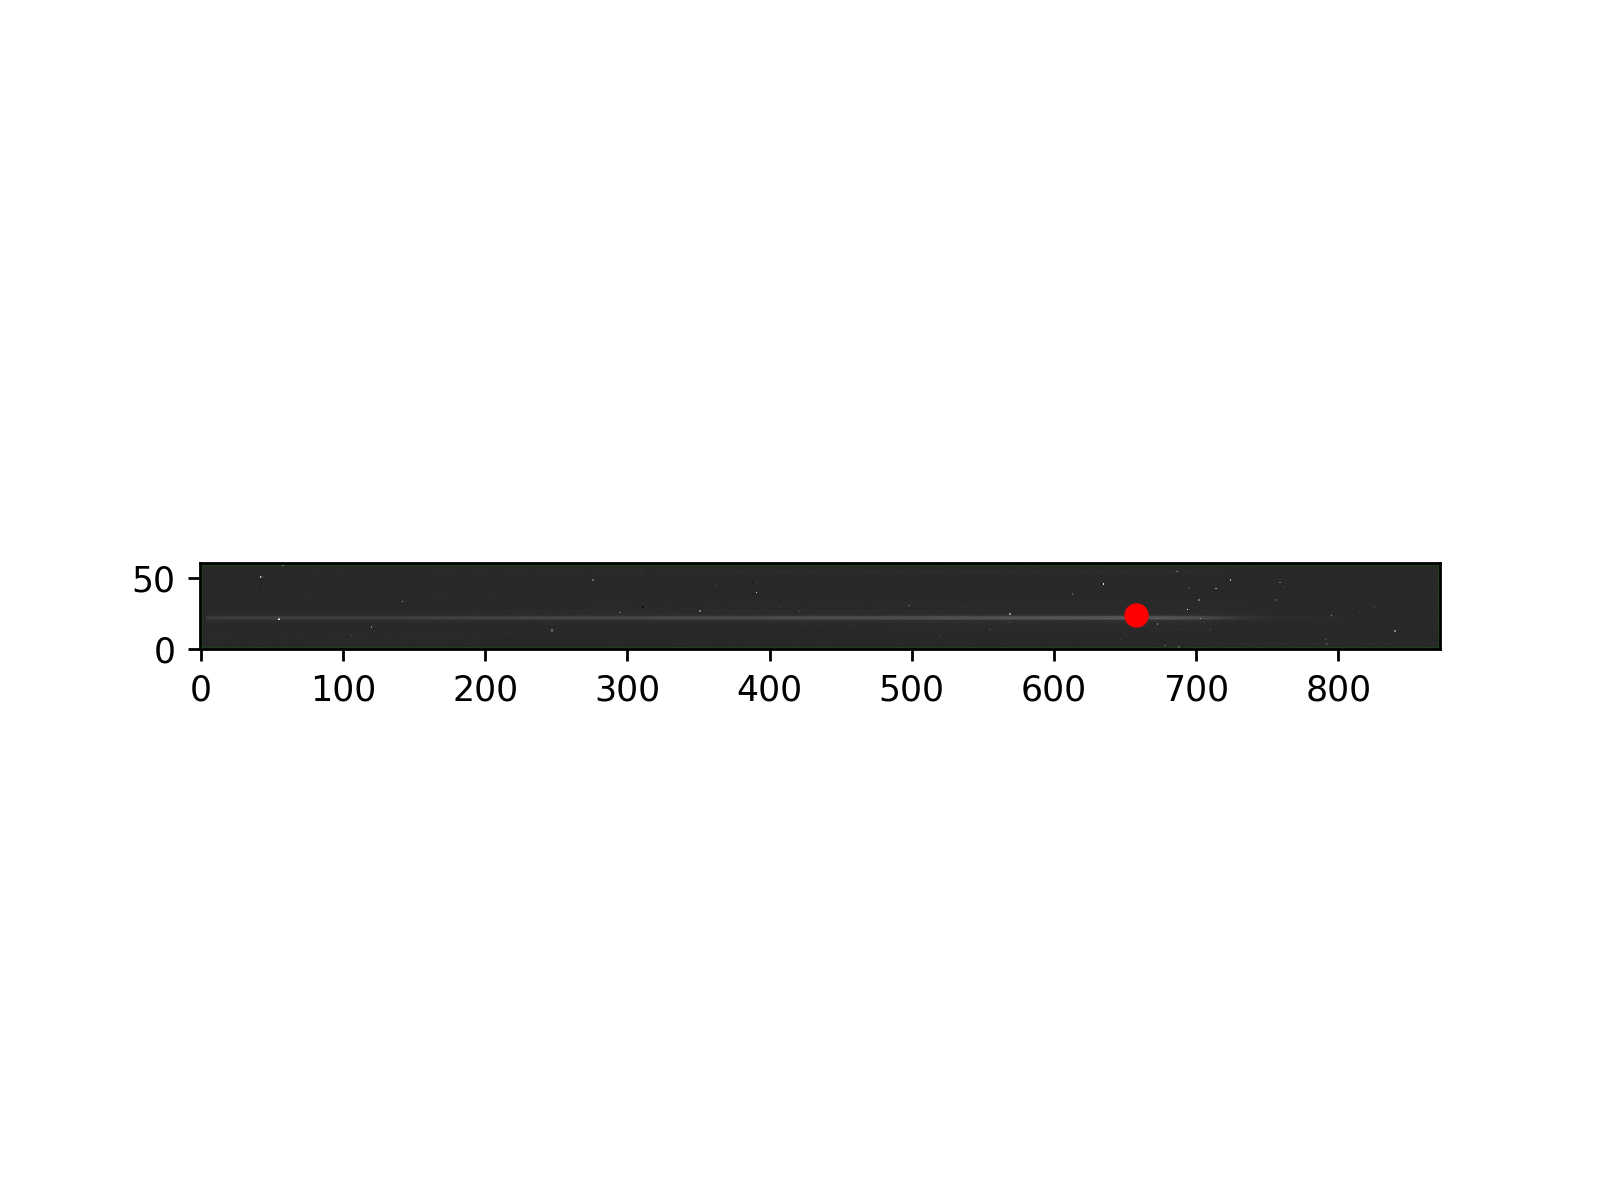

In [43]:
ax = plt.subplot(111)

ax.add_patch(patches.Rectangle((bbox[0][0], bbox[1][0]), 
                                bbox[0][1]-bbox[0][0], bbox[1][1]-bbox[1][0], edgecolor='g',
                                fill=False))
plt.imshow(s0.data, origin='lower')
plt.scatter(s0.source_xpos-xstart, s0.source_ypos-ystart, c='r')

#### extract_1d

The photometric correction is done before extract_1d is run.

The extraction region is taken to be the full size of the input subarray or cutout, or it could be restricted to the region within which the world coordinate system is defined. 

Optimal extraction is not implemented in the pipeline yet.

### The grism transforms in detail

In [ ]:
t = xmodel(x-x0)
dy = ymodel(t)
wav = lmodel(t)
print(x0, y0+dy, wav, order,t)

In [ ]:
# inverse
t = lmodel(wav)
dx = xmodel(t)
dy = ymodel(t)
# return x+dx, y+dy, x, y, order
print(dx, dy, x, y, order)

In [ ]:
# Compute the **t** parameter described in grismconf. 
# For a row dispersed image it is xdirect - x0
tmodel = astmath.SubtractUfunc() | xmodel

# The displacement in y is computed by passing **t** as input to the dispy polynomial

dy = tmodel| ymodel
dl = tmodel | lmodel

# inputs are xirect, ydirect, x0, y0, order

model = Mapping((0, 2, 0, 2, 2, 3, 4)) | \

# inputs are xdirect, x0,     xdirect, x0,      x0, y0, order
        (tmodel | ymodel) & (tmodel | lmodel) & Identity(3) |\

# inputs are dy, dl, x0, y0, order
        Mapping((2, 3, 0, 1, 4)) | \

# inputs are x0,     y0, dy,                dl, order
        Identity(1) & astmath.AddUfunc() &  Identity(2)

# outputs are x0, y0 + dy, dl, order)

In [ ]:
from astropy.io import fits
from astropy.table import QTable
from jwst import datamodels

In [ ]:


order = 1
xmodel = invdispx[order -1]
ymodel = dispy[order-1]
lmodel = displ[order-1]

In [ ]:
print(dispy)